# Import

In [30]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error, median_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc
import seaborn as sns
import matplotlib.pyplot as plt

# np.random.seed(42)

pd.set_option('display.max_columns', None)
rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)

import warnings
warnings.filterwarnings("ignore")


# Data


In [31]:
data5 = pd.read_excel('./于小鹏 机器学习5.xlsx')
data4 = pd.read_excel('./于小鹏 机器学习4 - 副本.xlsx')

In [32]:
data5

,总体生存时间,生存状态（编码）,feature_2,feature_3,feature_4,feature_5,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28,TNM分期（编码汇总）,淋巴清扫
0,6.907895,0,0,1,58,1,1,5.68,51.20,43.10,3.20,42.30,1,19.00,14.90,42.10,11.9,1,2,2,0,3.2,1,0,1,0,1
1,18.519737,0,0,1,48,1,1,12.01,50.40,37.60,2.50,15.00,1,39.00,18.40,40.70,13.0,1,1,2,0,8.0,1,0,0,0,1
2,24.309210,0,0,2,76,0,1,8.99,52.10,37.00,1.70,1.80,0,19.00,14.00,41.90,12.6,1,1,1,0,5.1,1,0,1,0,1
3,9.440789,0,0,1,55,0,1,5.74,55.30,36.80,3.20,3.30,0,18.00,15.30,44.10,11.7,1,2,1,0,8.5,0,1,2,1,0
4,57.105263,1,0,1,51,1,1,9.02,60.30,32.80,3.70,2.10,0,12.00,14.40,41.00,10.9,1,2,2,0,4.7,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,11.233334,1,0,1,41,1,1,7.62,6.45,0.62,710.80,1.46,0,14.00,13.01,30.37,12.6,1,2,1,0,5.2,1,1,1,1,0
389,11.500000,1,1,1,59,1,2,2.28,1.34,0.58,280.30,3.29,0,50.61,49.94,34.89,18.7,2,2,1,1,4.0,1,0,2,1,0
390,16.000000,1,0,1,58,0,0,3.78,3.08,0.54,3.27,1.27,1,33.00,19.80,46.80,13.4,1,3,1,1,3.0,0,0,2,0,0
391,21.733334,1,1,2,54,0,1,6.39,5.39,0.49,2.17,338.00,1,9.00,11.67,37.73,14.0,1,2,1,0,9.0,1,0,2,1,0


In [33]:
data5.describe()


,总体生存时间,生存状态（编码）,feature_2,feature_3,feature_4,feature_5,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28,TNM分期（编码汇总）,淋巴清扫
count,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000
mean,27.167872,0.676845,0.264631,1.470738,57.557252,0.277354,0.389313,6.580051,7.608880,2.987812,29.397628,10.537351,0.582697,40.784962,29.969389,40.751323,11.865929,1.111959,2.348601,1.096692,0.343511,5.371501,0.458015,0.157761,1.368957,0.559796,0.692112
std,21.870527,0.468278,0.441699,0.499779,9.819670,0.448263,0.587791,2.139456,13.980249,6.006594,133.323464,34.836997,0.493742,49.419389,58.302403,5.340986,1.529274,0.315718,0.587371,0.295915,0.475486,2.816180,0.498869,0.364981,0.587934,0.497044,0.462208
min,1.500000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,2.280000,1.320000,0.150000,0.650000,0.200000,0.000000,6.000000,3.600000,24.400000,1.100000,1.000000,1.000000,1.000000,0.000000,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.733333,0.000000,0.000000,1.000000,50.000000,0.000000,0.000000,5.110000,3.100000,1.210000,2.170000,1.560000,0.000000,17.000000,10.500000,37.600000,10.800000,1.000000,2.000000,1.000000,0.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,22.000000,1.000000,0.000000,1.000000,59.000000,0.000000,0.000000,6.300000,4.070000,1.580000,3.200000,2.890000,1.000000,25.000000,13.470000,41.200000,11.700000,1.000000,2.000000,1.000000,0.000000,5.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,38.000000,1.000000,1.000000,2.000000,64.000000,1.000000,1.000000,7.650000,5.460000,2.030000,6.400000,5.240000,1.000000,41.000000,19.200000,44.000000,12.700000,1.000000,3.000000,1.000000,1.000000,7.000000,1.000000,0.000000,2.000000,1.000000,1.000000
max,120.066667,1.000000,1.000000,2.000000,83.000000,1.000000,2.000000,15.340000,87.200000,43.100000,1404.000000,338.000000,1.000000,370.000000,400.300000,78.300000,18.700000,2.000000,3.000000,2.000000,1.000000,17.000000,1.000000,1.000000,2.000000,1.000000,1.000000


<AxesSubplot:xlabel='feature_14', ylabel='总体生存时间'>

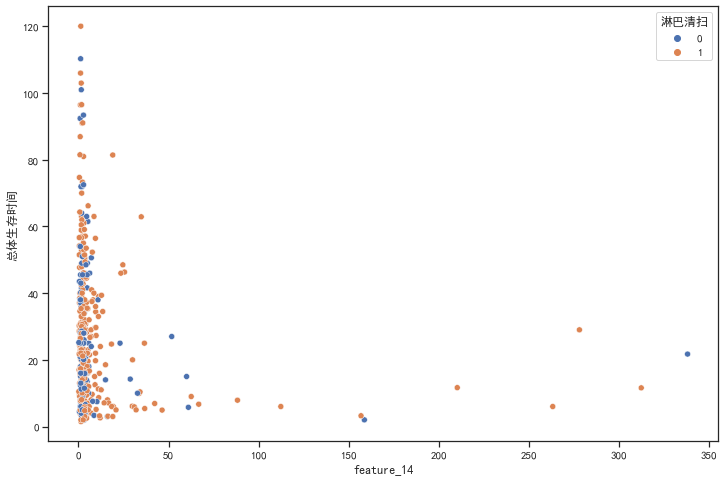

In [34]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=data5['feature_14'], y=data5['总体生存时间'], hue=data5['淋巴清扫'])

# preprocess

## feature selection

In [35]:
with_ftr = [
    "feature_25",
    "feature_20",
    "feature_2",
    "feature_21",
    "feature_14",
    "feature_15",
    "feature_7",
    "feature_13",
    "feature_26",
    "feature_24",
    "淋巴清扫",
    "TNM分期（编码汇总）",
    "总体生存时间",
]

without_ftr = [
    "feature_14",
    "feature_22",
    "feature_15",
    "feature_3",
    "feature_26",
    "feature_20",
    "feature_7",
    "feature_24",
    "feature_21",
    "feature_25",
    "淋巴清扫",
    "TNM分期（编码汇总）",
    "总体生存时间",
]


## Deal with raw data

In [36]:
def get_class(target):
    if target < 12:
        return 0
    elif target < 24:
        return 1
    elif target < 36:
        return 2
    elif target < 48:
        return 3
    elif target < 60:
        return 4
    else:
        return 5

data5['总体生存时间'] = data5['总体生存时间'].apply(get_class)

<AxesSubplot:>

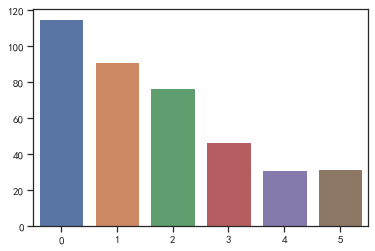

In [37]:
sns.barplot(y=data5['总体生存时间'].value_counts().values, x=data5['总体生存时间'].value_counts().index)

In [38]:
# # 11, 12, 13, 14, 15, 16, 17
df = data5.copy()
# abnormal = (df['feature_11'] > 20) | (df['feature_12'] > 15) | (df['feature_13'] > 1000) | (df['feature_14'] > 100) | (df['feature_15'] > 2500) | (df['feature_16'] > 200) | (df['feature_17'] > 100) | (df['feature_19'] < 2.5)
# df = df[~abnormal]

In [39]:
with_ = df[df['淋巴清扫'] == 1]
without_ = df[df['淋巴清扫'] == 0]

with_ = pd.DataFrame(with_, columns=with_ftr)
without_ = pd.DataFrame(without_, columns=without_ftr)

with_.drop(['淋巴清扫'], axis=1, inplace=True)
without_.drop(['淋巴清扫'], axis=1, inplace=True)

## Nomalization

In [11]:
scaler = StandardScaler()
# scaler = MinMaxScaler()

def scale(scaler, df):
    x = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    
    # x = df.iloc[:, 0:].values
    # y = df.iloc[:, 0].values
    
    x = scaler.fit_transform(x)
    # y = scaler.fit_transform(y.reshape(-1, 1))
    return x, y

In [12]:
with_x, with_y = scale(scaler, with_)
without_x, without_y = scale(scaler, without_)

# x, y = scale(scaler, df)

## Split into training set and test set

In [13]:
with_train_x, with_valid_x, with_train_y, with_valid_y = train_test_split(with_x, with_y, test_size=0.1, random_state=1)
without_train_x, without_valid_x, without_train_y, without_valid_y = train_test_split(without_x, without_y, test_size=0.1, random_state=1)

with_train_x.shape, with_valid_x.shape

# train_x, valid_x, train_y, valid_y = train_test_split(df.iloc[:, 0:], df.iloc[:, 0], test_size=0.1, random_state=42)

# train_x.shape, valid_x.shape

((189, 11), (22, 11))

In [14]:
without_train_x.shape, without_valid_x.shape

((99, 11), (11, 11))

# Model

In [15]:
def model_eval(model, x, y, valid_x, valid_y):
    model.fit(x, y)
    pred = model.predict(valid_x)
    proba = model.predict_proba(valid_x)
    
    acc = accuracy_score(valid_y, pred)
    precision = precision_score(valid_y, pred, average='macro')
    recall = recall_score(valid_y, pred, average='macro')
    f1 = f1_score(valid_y, pred, average='macro')

    auc = roc_auc_score(valid_y, proba, multi_class='ovo', labels=[0, 1, 2, 3, 4, 5])
    return acc, precision, recall, f1, auc

In [16]:
with_results = {}
without_results = {}
models = {
    # "LinearRegression": LinearRegression(),
    # "NeuralNetwork": MLPRegressor(max_iter=1000),
    # "DecisionTree": DecisionTreeRegressor(),
    # "SupportVectorMachine": SVR(),
    # "RandomForest": RandomForestRegressor(),
    # "KNeighbors": KNeighborsRegressor(),
    # "Ridge": Ridge(),
    # "Lasso": Lasso(),
    # "ElasticNet": ElasticNet(),
    "MLPClassifier": MLPClassifier(learning_rate="adaptive", max_iter=500),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "SupportVectorMachineClassifier": SVC(probability=True),
    "RandomForestClassifier": RandomForestClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
}

for name, model in models.items():
    acc, precision, recall, f1, auc = model_eval(
        model,
        # with_.iloc[:, :-1],
        # with_.iloc[:, -1],
        # with_.iloc[:, :-1],
        # with_.iloc[:, -1],
        with_train_x,
        with_train_y,
        with_valid_x,
        with_valid_y
    )
    with_results[name] = [acc, precision, recall, f1, auc]
for name, model in models.items():
    acc, precision, recall, f1, auc = model_eval(
        model,
        # without_.iloc[:, :-1],
        # without_.iloc[:, -1],
        # without_.iloc[:, :-1],
        # without_.iloc[:, -1],
        without_train_x,
        without_train_y,
        without_valid_x,
        without_valid_y
    )
    without_results[name] = [acc, precision, recall, f1, auc]

# for name, model in models.items():
#     acc, precision, recall, f1, auc = model_eval(
#         model,
#         train_x,
#         train_y,
#         valid_x,
#         valid_y,
#     )
#     with_results[name] = [acc, precision, recall, f1, auc]

In [17]:
df1 = pd.DataFrame(with_results, index=['accuracy', 'precision', 'recall', 'f1_score', 'AUC'])
df1

,MLPClassifier,DecisionTreeClassifier,SupportVectorMachineClassifier,RandomForestClassifier,KNeighborsClassifier
accuracy,0.181818,0.136364,0.181818,0.181818,0.136364
precision,0.095833,0.083333,0.083333,0.115476,0.060847
recall,0.104167,0.076389,0.125000,0.133333,0.083333
f1_score,0.099537,0.079365,0.100000,0.121905,0.069519
AUC,0.535937,0.459375,0.440625,0.423438,0.406250


In [18]:
df2 = pd.DataFrame(without_results, index=['accuracy', 'precision', 'recall', 'f1_score', 'AUC'])
df2

,MLPClassifier,DecisionTreeClassifier,SupportVectorMachineClassifier,RandomForestClassifier,KNeighborsClassifier
accuracy,0.272727,0.090909,0.000000,0.181818,0.090909
precision,0.200000,0.055556,0.000000,0.100000,0.033333
recall,0.366667,0.055556,0.000000,0.133333,0.100000
f1_score,0.250000,0.055556,0.000000,0.114286,0.050000
AUC,0.538889,0.425000,0.331944,0.412500,0.459028


# Plot

In [19]:
# ## 得到每个特征的直方图
# plt.figure(figsize=(15, 6))
# for i, name in enumerate(with_.columns):
#     plt.subplot(3, 4, i + 1)
#     plt.hist(with_.iloc[:, i], 25, color="green", alpha=0.5)
#     plt.title(name)

# plt.subplots_adjust()
# plt.show()

In [20]:
# sns.pairplot(with_, diag_kind='bar')